**adaBoost**

Евгений Борисов borisov.e@solarl.ru

---

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

---

In [2]:
from time import time
def get_seed(): t = time() ; return int(((t%1)/(t//1))*1e11)

In [3]:
n_samples = 1500
n_cls = 2

In [4]:
from sklearn.datasets import make_moons
X,y = make_moons(n_samples=n_samples, noise=.09, random_state=get_seed())

In [5]:
X = (X-X.min(axis=0))/(X.max(axis=0)-X.min(axis=0))
y = y*2-1

In [6]:
X.shape, y.shape

((1500, 2), (1500,))

---

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.6, random_state=512)
y_train.shape[0], y_test.shape[0]

(600, 900)

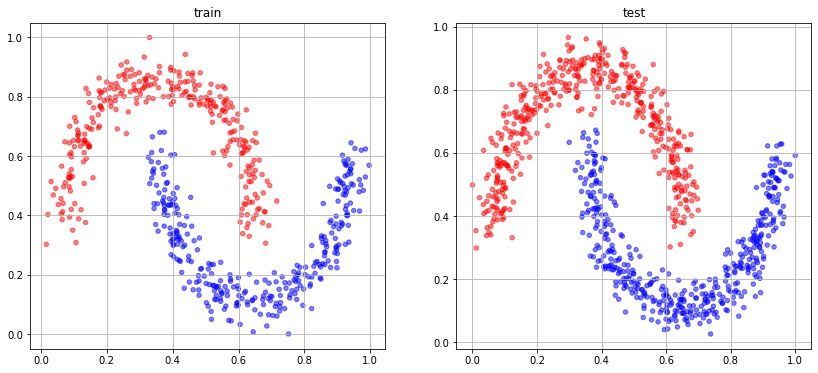

In [8]:
f, axarr = plt.subplots(1,2, sharey=False, sharex=False, figsize=(14,6),)

i=0
axarr[i].set_title('train')
axarr[i].scatter( x=X_train[:,0], 
             y=X_train[:,1], 
             c=[ 'b' if(j>0) else 'r' for j in y_train ], 
             s=20,
             alpha=0.5 )
axarr[i].grid()

i+=1
axarr[i].set_title('test')
axarr[i].scatter( x=X_test[:,0], 
             y=X_test[:,1], 
             c=[ 'b' if(j>0) else 'r' for j in y_test], 
             s=20,
             alpha=0.5 )
axarr[i].grid()

plt.show()

In [9]:
%xdel X
%xdel y

---

In [10]:
# пороговый классификатор отказами
#    вход, номер признака, порог, знак классификатора [-1,0,1]
def stumb(X,i,b,s): 
    return s*np.sign(X[:,i]-b)

In [11]:
# взвешенная суммарная ошибка классификатора h
def err_count(X,i,b,s,w,y): 
    o = stumb(X,i,b,s) # ответ классификатора
    r = o*y<0 # ответ ошибочный и не отказ (!=0)
    return (r*w).sum() # взвешенная суммарная ошибка

# разделение набора с наименьшей ошибкой
#    вход, веса примеров, знак классификатора, метки примеров, количество порогов для выбора 
def search_split(X,w,s,y,nb=30):
    # список порогов для каждого признака
    b = np.vstack([ np.linspace( X[:,i].min(), X[:,i].max(), nb )[1:-1] 
                    for i in range(X.shape[1]) ])
    
    # количество ошибок для разных признаков и значений порогов 
    err = np.array([ 
        [ err_count(X,i,b[i,j],s,w,y) for i in range(X.shape[1]) ]     
        for j in range(b.shape[1]) 
    ])
    
    # параметры с минимальным значением ошибок
    j,i = np.unravel_index(err.argmin(),err.shape)

    return i,b[i,j],err[j,i] # номер признака, порог, значение ошибки

def stumb_train (X,w,y):
    # классификатор y=[x>b]
    i0,b0,err0 = search_split(X_train,w,1,y_train)
    # классификатор y=[x<b]
    i1,b1,err1 = search_split(X_train,w,-1,y_train)
    
    # выбираем классификатор с меньшей ошибкой
    i,b,s = (i0,b0,1) if (err0<err1) else (i1,b1,-1)
    
    return i,b,s

In [12]:
# ответ композиции классификаторов r для входа X
def run(X,r): 
    return np.sign(np.sum([ a*stumb(X,i,b,s) for a,i,b,s in r ],axis=0)) 

In [13]:
# значение ф-ции потери для композиции классификаторов r для входа X и меток y
def loss(X,r,y): 
    return np.exp(-y*np.sum([ a*stumb(X,i,b,s) for a,i,b,s in r ],axis=0)).sum()/X.shape[0]

In [14]:
# веса объектов учебной выборки
w = np.ones(X_train.shape[0])/X_train.shape[0]
r=[] # параметры классификаторов композиции
ERR_BOUND=0.07 # порог ошибки

In [15]:
err_hist = []

# добавка для расчёта веса a компоненты на случай отсутствия ошибок 
d=1.0/X_train.shape[0] 

for jj in range(100):
    # обучаем базовый классификатор
    i,b,s = stumb_train(X_train,w,y_train)

    o=stumb(X_train,i,b,s) # ответ обученного базового классификатора
        
    p = ((o*y_train>0)*w).sum() # сумма весов правильных ответов
    n = ((o*y_train<0)*w).sum() # сумма весов ошибочных ответов
    # (o==0).sum() # количество отказов
    
    # базовый классификатор должен выдавать результат 
    # лучше чем случайный выбор 
    if( n > 0.5 ): break 
      
    a = 0.5*np.log((p+d)/(n+d)) # вычисляем вес классификатора
    
    # добавляем классификатор в композицию
    r.append([a,i,b,s])
    
    # считаем значение ошибки композиции 
    err_hist.append(loss(X_train,r,y_train))

    # проверяем достижение порога ошибки
    if err_hist[-1] < ERR_BOUND: break
        
    # обновляем веса объектов
    w = w*np.exp( -a*y_train*o )
    w = w/w.sum()


In [16]:
len(r),min(err_hist)

(23, 0.06695369212862744)

In [17]:
# loss(X_train,r,y_train),loss(X_test,r,y_test)

In [18]:
# нормируем веса классификаторов
a_sum = sum([ ri[0] for ri in r ])
r = [ [a/a_sum,i,b,s] for a,i,b,s in r ]

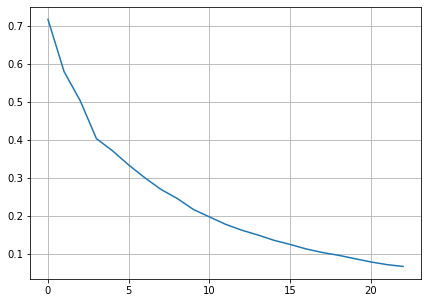

In [19]:
# изменение ошибки обучения
plt.figure(figsize=(7,5))
plt.plot(err_hist)
plt.grid()
plt.show()

In [20]:
o = run(X_test,r)

In [21]:
(o==y_test).sum()/y_test.shape[0] # accuracy - доля правильных ответов 

0.9944444444444445

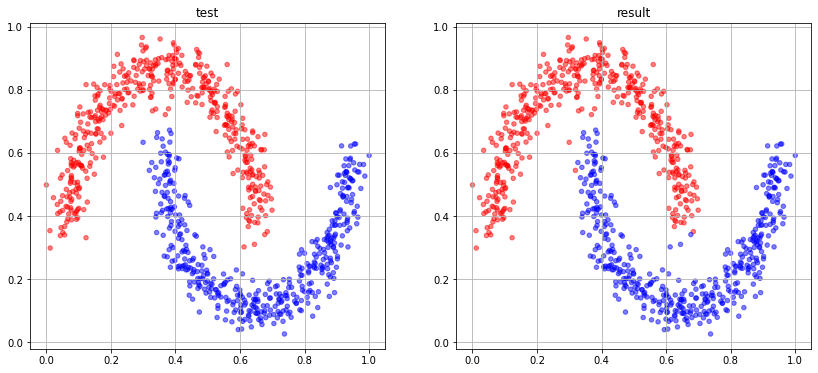

In [22]:
f, axarr = plt.subplots(1,2, sharey=False, sharex=False, figsize=(14,6),)

i=0
axarr[i].set_title('test')
axarr[i].scatter( x=X_test[:,0], 
             y=X_test[:,1], 
             c=[ 'b' if(j>0) else 'r' for j in y_test], 
             s=20,
             alpha=0.5 )
axarr[i].grid()

i+=1
axarr[i].set_title('result')
axarr[i].scatter( x=X_test[:,0], 
             y=X_test[:,1], 
             c=[ 'b' if(j>0) else 'r' for j in o], 
             s=20,
             alpha=0.5 )
axarr[i].grid()



plt.show()